## EfficientNetB0 - train

- https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43

### Configration

In [1]:
# モジュールの動的import(import先のファイルが更新されたときに追従する)
%load_ext autoreload
%autoreload 2

In [2]:
import os, gc

import numpy as np
import polars as pl
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

print("TensorFlow version =", tf.__version__)

2024-04-01 20:47:20.281488: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 20:47:20.409392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 20:47:20.409476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 20:47:20.431506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 20:47:20.483716: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version = 2.15.0


In [3]:
# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

Using 1 GPU


2024-04-01 20:47:22.117865: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-01 20:47:22.141122: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-01 20:47:22.141276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [32]:
from src.cfg.v1 import CFG

In [5]:
# 自動混合精度の設定
# https://cocoinit23.com/tensowflow-automatic-mixed-precision/
if CFG.MIX:
  tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
  print("Mixed precision enabled")
else:
  print("Using full precision")

Mixed precision enabled


### Load train csv

In [6]:
train_df = pl.read_csv(os.path.join(CFG.BASE_PATH, "train.csv"))
label_columns = train_df.columns[-6:]

print("Train shape: ", train_df.shape)
print("label columns: ", list(label_columns))
train_df.head()

Train shape:  (106800, 15)
label columns:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0


#### Create Non-Overlapping eeg_id train data

In [7]:
agg_columns = [
  pl.col("spectrogram_id").first().alias("spectrogram_id"),
  pl.col("spectrogram_label_offset_seconds").min().alias("min"),
  pl.col("spectrogram_label_offset_seconds").max().alias("max"),
  pl.col("patient_id").first().alias("patient_id"),
]
agg_columns += [pl.col(v).sum().alias(v) for v in label_columns] # 後で割合を出す

processed_train_df = train_df.group_by("eeg_id").agg(agg_columns)

# label_columnsそれぞれの割合を出す
label_data = processed_train_df.select(label_columns).to_numpy()
label_data = label_data / label_data.sum(axis=1, keepdims=True)

processed_train_df[label_columns] = label_data

# label
tmp_df = train_df.group_by("eeg_id").agg(pl.col("expert_consensus").first().alias("label"))
processed_train_df = processed_train_df.join(tmp_df, on="eeg_id", how="left")

print("Train non-overlap eeg_id shape: ", processed_train_df.shape)
processed_train_df.head()

Train non-overlap eeg_id shape:  (17089, 12)


eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,label
i64,i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,str
4171081843,635965361,0.0,22.0,40820,0.0,0.0,0.0,0.333333,0.666667,0.0,"""GRDA"""
849099816,1137130161,0.0,38.0,56450,0.0,1.0,0.0,0.0,0.0,0.0,"""LPD"""
1516436739,162082221,0.0,0.0,8588,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""
2250860233,1980523509,788.0,796.0,28488,0.0,0.666667,0.0,0.0,0.0,0.333333,"""LPD"""
2260502595,141987430,0.0,0.0,61262,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""


### Load train spectrograms

In [8]:
%%time
files = os.listdir(CFG.SPEC_FILE_PATH)
print(f"There are {len(files)} spectrogram parquets")

specs = {}
for v in files:
  tmp_df = pl.read_parquet(os.path.join(CFG.SPEC_FILE_PATH, v))
  name = int(v.split('.')[0])

  specs[name] = tmp_df.drop("time").to_numpy()

print(specs[355932412])

There are 11138 spectrogram parquets


[[1.745e+01 2.443e+01 4.322e+01 ... 5.000e-02 6.000e-02 6.000e-02]
 [2.023e+01 2.412e+01 3.494e+01 ... 2.000e-02 2.000e-02 2.000e-02]
 [1.380e+01 1.441e+01 2.312e+01 ... 3.000e-02 4.000e-02 3.000e-02]
 ...
 [1.217e+01 1.056e+01 1.605e+01 ... 3.000e-02 4.000e-02 4.000e-02]
 [2.046e+01 2.354e+01 3.197e+01 ... 3.000e-02 7.000e-02 4.000e-02]
 [3.894e+01 4.162e+01 4.446e+01 ... 3.000e-02 5.000e-02 5.000e-02]]
CPU times: user 5min 31s, sys: 2min 11s, total: 7min 42s
Wall time: 1min 28s


### Load train eeg

In [9]:
%%time
files = os.listdir(CFG.EEG_SPEC_FILE_PATH)
print(f"There are {len(files)} eeg npy")

eegs = {}
for v in processed_train_df.select("eeg_id").to_numpy().flatten():
  tmp = np.load(os.path.join(CFG.EEG_SPEC_FILE_PATH, f"{v}.npy"))

  eegs[v] = tmp

print(eegs[1954249952])

There are 17089 eeg npy
[[[ 0.4702314   0.47229955  0.39390743  0.09708871]
  [ 0.5895443   0.6836575   0.40573955  0.14630575]
  [ 0.56422716  0.6393467   0.41305214  0.32689607]
  ...
  [ 0.502146    0.5117412   0.7271438   0.6123129 ]
  [ 0.5437951   0.57669353  0.7712028   0.58248925]
  [ 0.75033367  0.73816514  0.76706684  0.6143571 ]]

 [[ 0.4719319   0.47399047  0.39316007  0.12782656]
  [ 0.5920356   0.6832855   0.42210817  0.14357562]
  [ 0.5639056   0.63773596  0.4291815   0.32836893]
  ...
  [ 0.50192666  0.54221076  0.72441006  0.6081852 ]
  [ 0.5455924   0.5963068   0.7671915   0.5786544 ]
  [ 0.7483314   0.7390824   0.762735    0.61193794]]

 [[ 0.4739076   0.47583944  0.39217794  0.14654142]
  [ 0.5946895   0.6827059   0.4319978   0.1400106 ]
  [ 0.56320137  0.63525254  0.43833345  0.32990664]
  ...
  [ 0.50126624  0.5618258   0.7207931   0.60285246]
  [ 0.54679424  0.61326903  0.7619387   0.57364744]
  [ 0.7457042   0.7400638   0.7570548   0.6087879 ]]

 ...

 [[-0.0289

### DataLoader

In [10]:
processed_train_df = processed_train_df.to_pandas()

In [11]:
! pip install -U albumentations

In [12]:
from src.loaders.dataloader_v1 import DataLoader

train_loader = DataLoader(
  df=processed_train_df,
  specs=specs,
  eegs=eegs,
  label_columns=label_columns,
  batch_size=32,
  shuffle=False,
)

In [13]:
train_loader.__getitem__(0)

(array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            3.50503087e-01,  4.05176401e-01,  3.18959802e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            3.38621527e-01,  5.77908158e-01,  4.86758500e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.63173580e-01,  6.07138157e-01,  5.30356944e-01],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            5.57670355e-01, -2.73432806e-02,  3.25294435e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            4.95566845e-01, -7.22923130e-03,  4.50091422e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            3.44358504e-01,  1.93023905e-02,  3.86535078e-01]],
 
         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            3.51313293e-01,  4.05305088e-01,  3.18465739e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
     

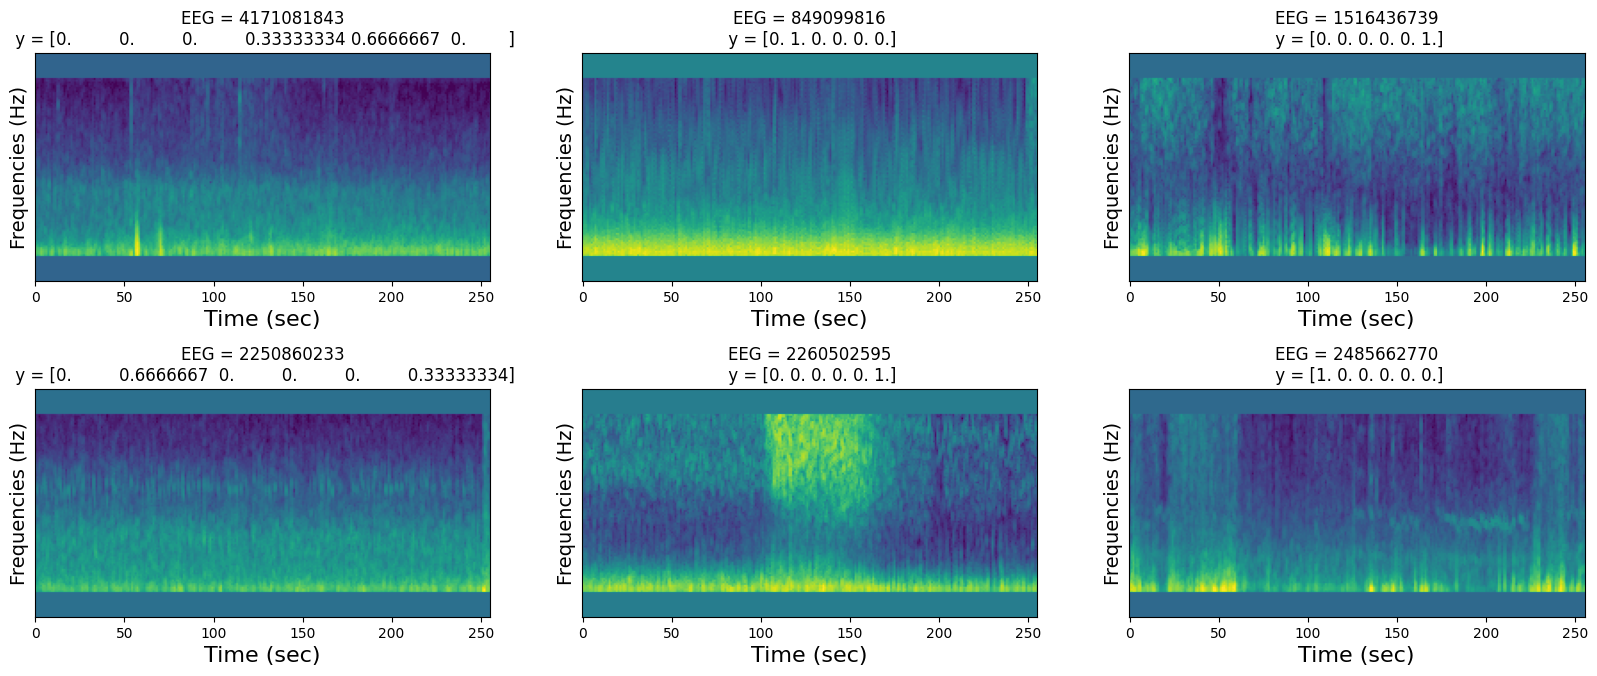

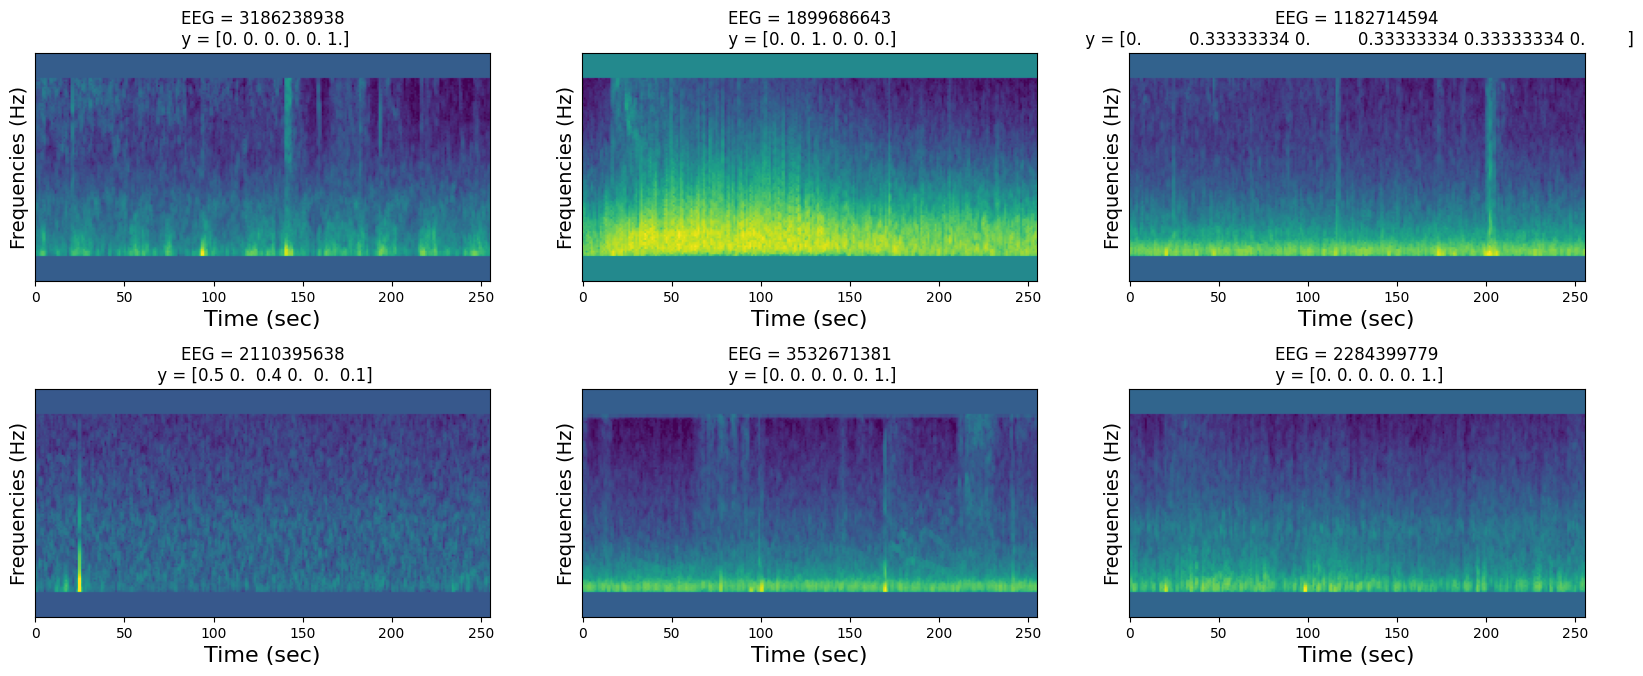

In [14]:
# dataloaderのスペクトログラム画像を表示

ROWS = 2
COLS = 3
BATCHES = 2

for i, (X, y) in enumerate(train_loader):
  plt.figure(figsize=(20,8))
  for j in range(ROWS):
    for k in range(COLS):
      plt.subplot(ROWS, COLS, j*COLS+k+1)

      img = X[j*COLS+k, :, :, 0][::-1,]

      min_value = img.flatten().min()
      max_value = img.flatten().max()
      img = (img-max_value) / (max_value-min_value)

      plt.imshow(img)

      y_s= y[j*COLS+k]

      y_texts = f"[{y_s[0]:0.2f}"
      for v in y_s[1:]:
        y_texts += f", {v:0.2f}"

      eeg = processed_train_df["eeg_id"].values[i*32+j*COLS+k]

      plt.title(f"EEG = {eeg}\n y = {y_s}", size=12)
      plt.yticks([])
      plt.ylabel("Frequencies (Hz)", size=14)
      plt.xlabel("Time (sec)", size=16)

  plt.show()

  if i == (BATCHES -1):
    break




### Train scheduler

- StepTrainScheduleで最初の4epochを学習
- LR = 1e-3 (1, 2epoch) -> 1e-4 (3epoch) -> 1e-5 (4epoch)

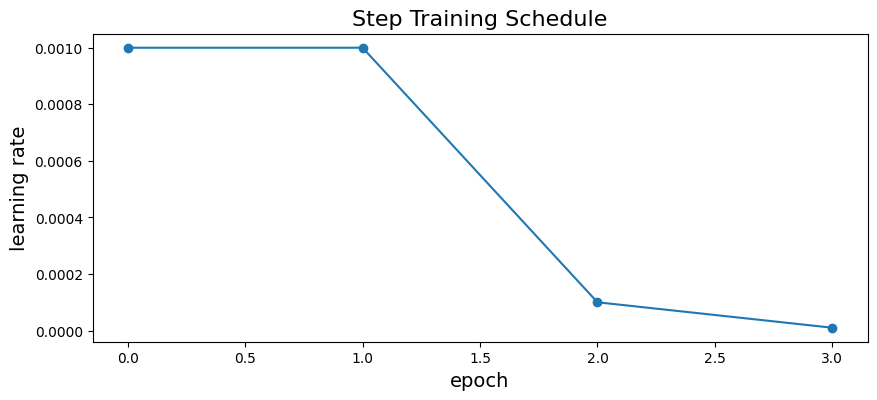

In [15]:
import math

def lrfn(epoch):
  if epoch < CFG.LR_RAMPUP_EPOCHS:
    lr = (CFG.LR_MAX - CFG.LR_START) / CFG.LR_RAMPUP_EPOCHS * epoch + CFG.LR_START
  elif epoch < (CFG.LR_RAMPUP_EPOCHS + CFG.LR_SUSTAIN_EPOCHS):
    lr = CFG.LR_MAX
  else:
    lr = CFG.LR_MAX * CFG.LR_STEP_DECAY ** ((epoch - CFG.LR_RAMPUP_EPOCHS - CFG.LR_SUSTAIN_EPOCHS) // CFG.EVERY)

  return lr

rng = [i for i in range(CFG.EPOCHS)]
y = [lrfn(x) for x in rng]

plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-')
plt.xlabel("epoch", size=14)
plt.ylabel("learning rate", size=14)
plt.title("Step Training Schedule", size=16)
plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


In [16]:
! pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
efficientnet is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [33]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

from src.models.efn_v1 import build_model

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_ix, valid_ix) in enumerate(gkf.split(processed_train_df, processed_train_df["label"], processed_train_df["patient_id"])):
  print(f"Fold {i+1}")

  train_loader = DataLoader(
    df=processed_train_df.iloc[train_ix],
    specs=specs,
    eegs=eegs,
    label_columns=label_columns,
    batch_size=32,
    shuffle=True,
    augment=True,
  )
  valid_loader = DataLoader(
    df=processed_train_df.iloc[valid_ix],
    specs=specs,
    eegs=eegs,
    label_columns=label_columns,
    batch_size=64,
    shuffle=False,
    mode="valid",
  )

  print(f"train size {len(train_ix)}, valid size {len(valid_ix)}")

  K.clear_session()

  with strategy.scope():
    model = build_model()

  if CFG.LOAD_MODELS_FROM_TRAIN == "":
    model.fit(
      train_loader,
      verbose=1,
      validation_data=valid_loader,
      epochs=CFG.EPOCHS,
      callbacks=[LR],
    )

    model.save_weights(f"/kaggle/output/EfficientNet_v{CFG.VER}_f{i}.weights.h5")
  else:
    model.load_weights(f"{CFG.LOAD_MODELS_FROM_TRAIN}/Efficient_v{CFG.VER}_f{i}.weights.h5")

  oof = model.predict(valid_loader, verbose=1)

  all_oof.append(oof)
  all_true.append(processed_train_df.iloc[valid_ix][label_columns].values)

  del model, oof
  gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

Fold 1
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.


2024-04-01 22:11:04.846647: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-04-01 22:11:09.197320: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 631/12140 nodes to float16 precision using 134 cast(s) to float16 (excluding Const and Variable casts)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 1.8169

2024-04-01 22:13:32.460872: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 409/1666 nodes to float16 precision using 116 cast(s) to float16 (excluding Const and Variable casts)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 160s 342ms/step - loss: 1.8168 - val_loss: 1.6313 - learning_rate: 0.0010


2024-04-01 22:13:39.439745: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 408/1549 nodes to float16 precision using 115 cast(s) to float16 (excluding Const and Variable casts)


53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

2024-04-01 22:13:45.469093: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 408/1599 nodes to float16 precision using 115 cast(s) to float16 (excluding Const and Variable casts)


54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step
Fold 2
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.


2024-04-01 22:13:53.431993: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-04-01 22:13:57.929390: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 631/12140 nodes to float16 precision using 134 cast(s) to float16 (excluding Const and Variable casts)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 1.8282

2024-04-01 22:16:21.364013: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 409/1666 nodes to float16 precision using 116 cast(s) to float16 (excluding Const and Variable casts)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 161s 342ms/step - loss: 1.8281 - val_loss: 2.0085 - learning_rate: 0.0010


2024-04-01 22:16:28.368719: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 408/1549 nodes to float16 precision using 115 cast(s) to float16 (excluding Const and Variable casts)


53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

2024-04-01 22:16:34.372914: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 408/1599 nodes to float16 precision using 115 cast(s) to float16 (excluding Const and Variable casts)


54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step
Fold 3
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.


2024-04-01 22:16:42.397936: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-04-01 22:16:46.906672: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 631/12140 nodes to float16 precision using 134 cast(s) to float16 (excluding Const and Variable casts)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 1.8142

2024-04-01 22:19:10.075948: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 409/1666 nodes to float16 precision using 116 cast(s) to float16 (excluding Const and Variable casts)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 160s 342ms/step - loss: 1.8141 - val_loss: 1.8451 - learning_rate: 0.0010


2024-04-01 22:19:17.062162: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 408/1549 nodes to float16 precision using 115 cast(s) to float16 (excluding Const and Variable casts)


53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

2024-04-01 22:19:23.077548: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 408/1599 nodes to float16 precision using 115 cast(s) to float16 (excluding Const and Variable casts)


54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step
Fold 4
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.


2024-04-01 22:19:31.223986: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-04-01 22:19:35.726602: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 631/12140 nodes to float16 precision using 134 cast(s) to float16 (excluding Const and Variable casts)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 1.8224

2024-04-01 22:21:59.323631: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 409/1666 nodes to float16 precision using 116 cast(s) to float16 (excluding Const and Variable casts)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 161s 343ms/step - loss: 1.8223 - val_loss: 1.7304 - learning_rate: 0.0010


2024-04-01 22:22:06.327143: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 408/1549 nodes to float16 precision using 115 cast(s) to float16 (excluding Const and Variable casts)


53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

2024-04-01 22:22:12.330914: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 408/1599 nodes to float16 precision using 115 cast(s) to float16 (excluding Const and Variable casts)


54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step
Fold 5
train size 13672, valid size 3417

Epoch 1: LearningRateScheduler setting learning rate to 0.001.


2024-04-01 22:22:20.408756: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2024-04-01 22:22:24.920025: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 631/12140 nodes to float16 precision using 134 cast(s) to float16 (excluding Const and Variable casts)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 1.7509

2024-04-01 22:24:48.114240: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 409/1666 nodes to float16 precision using 116 cast(s) to float16 (excluding Const and Variable casts)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 160s 342ms/step - loss: 1.7507 - val_loss: 1.8981 - learning_rate: 0.0010


2024-04-01 22:24:55.137773: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 408/1549 nodes to float16 precision using 115 cast(s) to float16 (excluding Const and Variable casts)


53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

2024-04-01 22:25:01.171990: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 408/1599 nodes to float16 precision using 115 cast(s) to float16 (excluding Const and Variable casts)


54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step


### CV score for EfficientNet

KL(=Kullback-Leibler) Divergenceによる性能評価
https://qiita.com/shuva/items/81ad2a337175c035988f

In [37]:
from src.metrics import kl_div

oof = pd.DataFrame(all_oof.copy())
oof["id"] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true["id"] = np.arange(len(true))

cv = kl_div.score(solution=true, submission=oof, row_id_column_name="id")

print("CV score KL-Div for EfficientNetB0=", cv)

[0.48052436 0.43536133 0.42739674 0.42703825 0.46056184 0.6517983 ]


ParticipantVisibleError: Target values in submission do not add to one within all rows